## Step 1: Tokenizer 및 TextClassifier의 encoder를 GPT로 변경

In [1]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 107.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.3 MB/s eta 0:00:00


In [2]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader

# GPT pre-trained tokenizer 불러오기
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'openai-gpt')

# GPT에 padding token이 없으므로, unknown token을 padding token으로 설정
tokenizer.pad_token = tokenizer.unk_token

# 데이터셋 로드
ds = load_dataset("fancyzhx/ag_news")

# collate_fn 함수 정의 (padding 적용)
def collate_fn(batch):
    texts, labels = [], []
    for row in batch:
        labels.append(row['label'])
        texts.append(row['text'])

    encoding = tokenizer(texts, padding=True, return_tensors="pt")
    input_ids = encoding["input_ids"]
    attention_mask = encoding["attention_mask"]
    labels = torch.LongTensor(labels)

    return input_ids, attention_mask, labels

# DataLoader 설정
train_loader = DataLoader(ds['train'], batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(ds['test'], batch_size=16, shuffle=False, collate_fn=collate_fn)


/usr/local/lib/python3.10/dist-packages/torch/hub.py:295: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://h

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/656 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/816k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/458k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

## Step 2: TextClassifier의 encoder를 GPT로 변경

In [3]:
from torch import nn

# GPT를 사용하는 텍스트 분류 모델 정의
class TextClassifier(nn.Module):
    def __init__(self):
        super(TextClassifier, self).__init__()
        self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'openai-gpt')
        self.classifier = nn.Linear(768, 4)  # 4개의 클래스

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        # GPT는 마지막 토큰의 representation을 사용
        x = outputs['last_hidden_state']
        x = self.classifier(x[:, -1])  # 마지막 토큰의 표현 사용
        return x

model = TextClassifier().to('cuda')

# CrossEntropyLoss 사용 (다중 클래스 분류)
loss_fn = nn.CrossEntropyLoss()


Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


model.safetensors:   0%|          | 0.00/479M [00:00<?, ?B/s]

## Step 3: 학습 및 평가 (수정 전)

In [4]:
# Optimizer 설정
from torch.optim import Adam
optimizer = Adam(model.parameters(), lr=0.0001)

# Accuracy 함수 정의
def accuracy(model, dataloader):
    cnt = 0
    acc = 0
    model.eval()

    with torch.no_grad():
        for data in dataloader:
            input_ids, attention_mask, labels = data
            input_ids, attention_mask, labels = input_ids.to('cuda'), attention_mask.to('cuda'), labels.to('cuda')

            preds = model(input_ids, attention_mask)
            preds = torch.argmax(preds, dim=-1)

            cnt += labels.size(0)
            acc += (preds == labels).sum().item()

    return acc / cnt

# 학습 루프 (그래프를 위해 매 epoch마다 train loss 출력 및 accuracy 저장)
n_epochs = 10
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(n_epochs):
    total_loss = 0
    model.train()

    for data in train_loader:
        input_ids, attention_mask, labels = data
        input_ids, attention_mask, labels = input_ids.to('cuda'), attention_mask.to('cuda'), labels.to('cuda')

        optimizer.zero_grad()
        preds = model(input_ids, attention_mask)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # 각 epoch가 끝난 후 train/test accuracy 측정
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)

    # 캐시 메모리 비우기
    torch.cuda.empty_cache()

    train_losses.append(total_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {total_loss:.4f} | Train Accuracy: {train_acc:.3f} | Test Accuracy: {test_acc:.3f}")


Epoch  1 | Train Loss: 2222.8881 | Train Accuracy: 0.933 | Test Accuracy: 0.917
Epoch  2 | Train Loss: 1670.9867 | Train Accuracy: 0.937 | Test Accuracy: 0.913
Epoch  3 | Train Loss: 6371.8285 | Train Accuracy: 0.250 | Test Accuracy: 0.250
Epoch  4 | Train Loss: 10410.5195 | Train Accuracy: 0.250 | Test Accuracy: 0.250
Epoch  5 | Train Loss: 10404.8462 | Train Accuracy: 0.250 | Test Accuracy: 0.250
Epoch  6 | Train Loss: 10403.7284 | Train Accuracy: 0.250 | Test Accuracy: 0.250
Epoch  7 | Train Loss: 10401.9335 | Train Accuracy: 0.250 | Test Accuracy: 0.250
Epoch  8 | Train Loss: 10401.1490 | Train Accuracy: 0.250 | Test Accuracy: 0.250
Epoch  9 | Train Loss: 10401.8005 | Train Accuracy: 0.250 | Test Accuracy: 0.250
Epoch 10 | Train Loss: 10401.4659 | Train Accuracy: 0.250 | Test Accuracy: 0.250


### 학습 중 발생한 문제 및 수정 과정

**문제 설명**:
기존 학습에서는 Epoch 3부터 **Train Accuracy**와 **Test Accuracy**가 모두 **25%**로 떨어지는 현상이 발견되었습니다. 이 문제는 학습이 비정상적으로 진행되어, 모델이 4개의 클래스 중 하나를 무작위로 선택하는 것과 같은 수준(25%)의 성능을 보인 것입니다.

### 그래서 아래와 같이 수정하였습니다:

- 학습률을 0.00001로 낮췄습니다.
- Gradient Clipping을 적용하여 학습 중 gradient 폭발 문제를 방지했습니다.
- Scheduler를 추가하여 성능 향상이 없을 때 학습률을 감소시켰습니다.

## Step 3: 학습 및 평가 (수정 후)

In [5]:
# Optimizer 설정
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_

optimizer = Adam(model.parameters(), lr=0.00001)  # 학습률을 더 낮게 설정

# Scheduler 설정 (ReduceLROnPlateau: 성능 향상이 없을 때 학습률을 감소)
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Accuracy 함수 정의
def accuracy(model, dataloader):
    cnt = 0
    acc = 0
    model.eval()

    with torch.no_grad():
        for data in dataloader:
            input_ids, attention_mask, labels = data
            input_ids, attention_mask, labels = input_ids.to('cuda'), attention_mask.to('cuda'), labels.to('cuda')

            preds = model(input_ids, attention_mask)
            preds = torch.argmax(preds, dim=-1)

            cnt += labels.size(0)
            acc += (preds == labels).sum().item()

    return acc / cnt

# 학습 루프 (매 epoch마다 train loss 출력 및 accuracy 저장)
n_epochs = 10
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(n_epochs):
    total_loss = 0
    model.train()

    for data in train_loader:
        input_ids, attention_mask, labels = data
        input_ids, attention_mask, labels = input_ids.to('cuda'), attention_mask.to('cuda'), labels.to('cuda')

        optimizer.zero_grad()
        preds = model(input_ids, attention_mask)
        loss = loss_fn(preds, labels)

        # Backward pass
        loss.backward()

        # Gradient Clipping 적용 (max_norm 값을 적절히 설정, 예: 5.0)
        clip_grad_norm_(model.parameters(), max_norm=5.0)

        # Optimizer step
        optimizer.step()

        total_loss += loss.item()

    # 각 epoch가 끝난 후 train/test accuracy 측정
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)

    # 캐시 메모리 비우기
    torch.cuda.empty_cache()

    train_losses.append(total_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {total_loss:.4f} | Train Accuracy: {train_acc:.3f} | Test Accuracy: {test_acc:.3f}")

    # Scheduler에 loss 값을 전달하여 학습률 조정
    scheduler.step(total_loss)


Epoch  1 | Train Loss: 1971.7654 | Train Accuracy: 0.940 | Test Accuracy: 0.926
Epoch  2 | Train Loss: 1254.2675 | Train Accuracy: 0.964 | Test Accuracy: 0.937
Epoch  3 | Train Loss: 917.0514 | Train Accuracy: 0.975 | Test Accuracy: 0.936
Epoch  4 | Train Loss: 669.4098 | Train Accuracy: 0.988 | Test Accuracy: 0.939
Epoch  5 | Train Loss: 483.5207 | Train Accuracy: 0.992 | Test Accuracy: 0.938
Epoch  6 | Train Loss: 364.2578 | Train Accuracy: 0.995 | Test Accuracy: 0.936
Epoch  7 | Train Loss: 287.1875 | Train Accuracy: 0.996 | Test Accuracy: 0.939
Epoch  8 | Train Loss: 237.5013 | Train Accuracy: 0.997 | Test Accuracy: 0.935
Epoch  9 | Train Loss: 204.8174 | Train Accuracy: 0.998 | Test Accuracy: 0.940
Epoch 10 | Train Loss: 183.9053 | Train Accuracy: 0.998 | Test Accuracy: 0.936


#### 위와 같이 수정한 결과 정상적으로 성능이 올라가는 것으로 보입니다.

## 정확도 그래프

Final Train Accuracy: 0.998 | Final Test Accuracy: 0.936


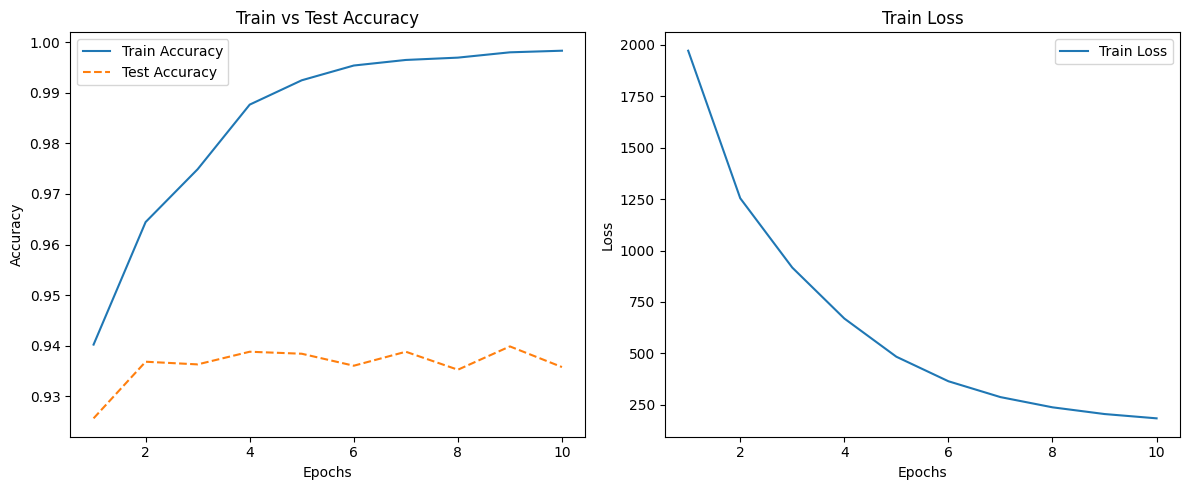

In [6]:
import matplotlib.pyplot as plt

# 학습 후 정확도 측정
final_train_acc = accuracy(model, train_loader)
final_test_acc = accuracy(model, test_loader)
print(f"Final Train Accuracy: {final_train_acc:.3f} | Final Test Accuracy: {final_test_acc:.3f}")

# 정확도 그래프 그리기
epochs = range(1, n_epochs + 1)
plt.figure(figsize=(12, 5))

# Train/Test Accuracy 변화 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, test_accuracies, label="Test Accuracy", linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy")
plt.legend()

# Train Loss 변화 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train Loss")
plt.legend()

plt.tight_layout()
plt.show()
